Import the required libraries

In [87]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

In [88]:
# Arange = from beginning to end-1

HoraIni = 1 #Hrs from failure
HoraFin = 1 #Hrs from failure
IniNor= 3*24 #Hrs start first sample of Normal
Window =30 #minutes of time series vector
Steps = 6#steps used on the same record (a record will have variables from t to the end of window according to the steps)

#Splitting the cycles in validation, testing and training
ele_val_data = np.arange(9,25)
ele_test_data = np.arange(0,9)
ele_train_data = np.arange(25,150)

fail = np.arange(HoraIni,HoraFin+1)
normal = np.arange(HoraIni+IniNor,HoraIni+IniNor+(HoraFin-HoraIni)+1)

In [89]:
fail

array([1])

In [90]:
normal

array([73])

Import the Data from Google Cloud storage

In [91]:
path = "gs://mdona-cloud-lab-ctrlsenales-bucket/DataSet_128_Var&Central_3.0_1minPeri.csv"
df_final = pd.read_csv(path, index_col=0)
df_final['TS'] = pd.to_datetime(df_final['TS'], infer_datetime_format=True)

df_final.head(4)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ID_LOCATION,ELEMENT,TS,TAG_SONDA_PB1,TAG_SONDA_PB2,TAG_PRESION_SATURACION,TAG_TEMP_ASPIRACION,TAG_RECALENT_VALVULA,TAG_APERT_VALVULA,TAG_PETICION_FRIO,...,TAG_POTENCIA_COMP5,TAG_POTENCIA_COMP6,TAG_SETPOINT_ASP,TAG_SETPOINT_COND,TAG_SONDA_ASP,TAG_SONDA_COND,TAG_SONDA_TEMP_EXT,TAG_SONDA_TEMP_SUBENF,cycle_number,RUL
0,29100,29115,2019-02-27 14:49:00,4.4,1.1,3.615385,7.5,9.2,100.0,1.0,...,0.0,0.0,-9.9,26.170911,3.651113,12.458347,14.479890,23.833389,1,239
1,29100,29115,2019-02-27 14:50:00,3.7,0.7,3.573077,5.1,7.8,100.0,1.0,...,0.0,0.0,-9.9,26.170822,3.651111,12.458331,14.479856,23.833324,1,239
2,29100,29115,2019-02-27 14:51:00,2.6,0.3,3.530769,2.7,6.4,100.0,1.0,...,0.0,0.0,-9.9,26.170732,3.651109,12.458315,14.479822,23.833259,1,239
3,29100,29115,2019-02-27 14:52:00,1.5,-0.1,3.488462,3.7,11.4,100.0,1.0,...,0.0,0.0,-9.9,26.170643,3.651106,12.458299,14.479789,23.833194,1,239


In [92]:
df_final.columns

Index(['ID_LOCATION', 'ELEMENT', 'TS', 'TAG_SONDA_PB1', 'TAG_SONDA_PB2',
       'TAG_PRESION_SATURACION', 'TAG_TEMP_ASPIRACION', 'TAG_RECALENT_VALVULA',
       'TAG_APERT_VALVULA', 'TAG_PETICION_FRIO', 'TAG_DESCARCHE',
       'SUM_PETICION_FRIO', 'SUM_DESCARCHE', 'TD_0_TAG_PETICION_FRIO',
       'TD_1_TAG_PETICION_FRIO', 'TD_0_TAG_DESCARCHE', 'TD_1_TAG_DESCARCHE',
       'TAG_POTENCIA_COMP1', 'TAG_POTENCIA_COMP2', 'TAG_POTENCIA_COMP3',
       'TAG_POTENCIA_COMP4', 'TAG_POTENCIA_COMP5', 'TAG_POTENCIA_COMP6',
       'TAG_SETPOINT_ASP', 'TAG_SETPOINT_COND', 'TAG_SONDA_ASP',
       'TAG_SONDA_COND', 'TAG_SONDA_TEMP_EXT', 'TAG_SONDA_TEMP_SUBENF',
       'cycle_number', 'RUL'],
      dtype='object')

In [93]:
elements_final= df_final['ELEMENT'].unique()
cycles_final= df_final['cycle_number'].unique()
print("Count of elements in final: ",len(elements_final))
print("Count of cycles in final: ",len(cycles_final))

Count of elements in final:  118
Count of cycles in final:  136


In [94]:
from dateutil.relativedelta import relativedelta

path = "gs://mdona-cloud-lab-ctrlsenales-bucket/PIC_TRACK_ALARMS.csv"
df_Alarms = pd.read_csv(path)

def Alarm_Detection( df_Alarms ):
    import pandas as pd

    df_Alarms = df_Alarms[df_Alarms['ID'] == 'Alarma Alta Temperatura en servicio']

    df_Alarms = df_Alarms[['IDEquipo']+['TS']+['Type']+['Equipo']+['Centro']+['IDCentro']+['IDZona']]



    df_Alarms = df_Alarms[df_Alarms['Equipo'].str.contains("Mural Carne|Mural Pescado")]

    df_Alarms.columns = ['ELEMENT', 'TS','ALTA_TEMPERATURA', 'Equipo', 'Centro', 'IDCentro', 'IDZona']




    #tranform the column TS to a datetime Object
    df_Alarms['TS'] = pd.to_datetime(df_Alarms['TS'], infer_datetime_format=True)

    first = df_Alarms['TS'].min()
    #Sort the values by the time
    df_Alarms = df_Alarms.sort_values(['ELEMENT','TS'], ascending=[ True, True]).reset_index(drop=True)

    #cols=list(df_Alarms.columns)

    #df_Alarms = df_Alarms[cols[0:2]+[cols[4]]]


    df_Alarms = df_Alarms.dropna().reset_index(drop=True)

    #papa pa paaaannnnnnnnnnnnnnnnnnnnnnnnnn
    #Check if the Begin was 'InhibitNotif' before the event occurred
    #Create a "new" column to indicate if it is an alarm or an alarm inhibited by user (on these cases it will have TRUE)

    for i, row  in df_Alarms.iterrows():
        if (df_Alarms.loc[i,'ALTA_TEMPERATURA']) =='Begin' and  (df_Alarms.loc[i-1,'ALTA_TEMPERATURA'])!='InhibitNotif':
            df_Alarms.at[i,'new'] = 'True'
        elif (df_Alarms.loc[i,'ALTA_TEMPERATURA']) =='Begin' and  (df_Alarms.loc[i-1,'ALTA_TEMPERATURA'])=='InhibitNotif':
            df_Alarms.at[i,'new'] = 'True but InhibitNotif by user'
        else:
            df_Alarms.at[i,'new'] = 'False'      

    df_InhibitAlarms = df_Alarms[df_Alarms['new'] == 'True but InhibitNotif by user']
    df_Alarms = df_Alarms[(df_Alarms['new'] == 'True') | (df_Alarms['new'] == 'True but InhibitNotif by user')]

    #df_Alarms = df_Alarms.drop('new', axis=1).reset_index(drop=True)
    df_Alarms = df_Alarms.sort_values(['ELEMENT','TS'], ascending=[ True, True]).reset_index(drop=True)

    #Check is the prior event occurred in a especific time
    '''

    for i in range(len(df_Alarms)):
        if i == 0: continue
        timedelta =((df_Alarms.loc[i,'TS'])-(df_Alarms.loc[i-1,'TS'])).days
        print("Es el mismo elemento que el anterior ", (df_Alarms.loc[i,'ELEMENT']) == (df_Alarms.loc[i-1,'ELEMENT']))
        print("Time Delta = ",timedelta)
    '''

    #Add a new column "new2" to indicate if there isn't any previous alarm in Days_before days
    #We discard the alarms that had another alarm in the Days_before previous days.
    
    for i, row  in df_Alarms.iterrows():
        Days_before = 11
        if i == 0:
            df_Alarms.at[i,'new2'] = 'True'
        elif (df_Alarms.loc[i,'ELEMENT']) == (df_Alarms.loc[i-1,'ELEMENT']):
            if ((df_Alarms.loc[i,'TS'])-(df_Alarms.loc[i-1,'TS'])).days >= Days_before:
                df_Alarms.at[i,'new2'] = 'True'
            else:
                df_Alarms.at[i,'new2'] = 'Too Short' 
        else:
            df_Alarms.at[i,'new2'] = 'True'

    df_Tooshort = df_Alarms[df_Alarms['new2'] == 'Too Short' ]

    df_Alarms = df_Alarms[df_Alarms['new'] == 'True']
    df_Alarms = df_Alarms[df_Alarms['new2'] == 'True']

    df_Alarms = df_Alarms.drop('new', axis=1).reset_index(drop=True)
    df_Alarms = df_Alarms.drop('new2', axis=1).reset_index(drop=True)
    df_Alarms = df_Alarms.sort_values(['ELEMENT','TS'], ascending=[ True, True]).reset_index(drop=True)

    #to check if the timedelta between the first event and the alarm is more than 15days 


    for i, row  in df_Alarms.iterrows():
        Days_From_beginning = 15
        if ((df_Alarms.loc[i,'TS'])-first).days >= Days_From_beginning:
            df_Alarms.at[i,'new'] = 'True'
        else:
            df_Alarms.at[i,'new'] = 'Not enough data' 

    df_Not_enough = df_Alarms[df_Alarms['new'] == 'Not enough data' ]


    df_Alarms = df_Alarms[df_Alarms['new'] == 'True']
    df_Alarms = df_Alarms.drop('new', axis=1).reset_index(drop=True)
    df_Alarms = df_Alarms.sort_values(['TS','ELEMENT'], ascending=[ True, True]).reset_index(drop=True)
    
    
    df_Alarms = df_Alarms.sort_values(['ELEMENT', 'TS'], ascending=[True, True]).reset_index(drop=True)
    
    #keep only the colums element, timestand and alarm
    df_Alarms = df_Alarms[['ELEMENT']+['TS']+['ALTA_TEMPERATURA']]
    
    
    #create a new row with a ten days prior the begin date
    for i in range(len(df_Alarms)):
        timeframe = df_Alarms.loc[i, 'TS'] - relativedelta(days=10)
        df_Alarms = df_Alarms.append({'TS':timeframe,'ELEMENT':(df_Alarms.loc[i, 'ELEMENT']),'ALTA_TEMPERATURA':'Start'}, ignore_index=True)
    
    df_Alarms = df_Alarms.sort_values(['ELEMENT', 'TS'], ascending=[True, True]).reset_index(drop=True)
    
    #create new column called cycle_number to difference the different cycles
    df_Alarms['cycle_number'] = df_Alarms['ALTA_TEMPERATURA'].map({'Start':0, 'Begin':1}).diff().lt(0).cumsum() + 1
    df_Alarms = df_Alarms[df_Alarms['ALTA_TEMPERATURA'] == 'Begin']
    df_Alarms= df_Alarms.drop(['ALTA_TEMPERATURA'], axis=1).reset_index(drop=True)

    

    return(df_Alarms)


#The function that apply the filter modifications to the dataset
df_Alarms = Alarm_Detection(df_Alarms)
df_Alarms

,ELEMENT,TS,cycle_number
0,29115,2019-03-09 14:48:09,1
1,31002,2019-03-20 09:11:00,2
2,31078,2019-06-13 09:54:00,3
3,31134,2019-04-29 06:35:00,4
4,31134,2020-03-08 10:29:00,5
...,...,...,...
153,140806,2020-06-15 07:35:00,154
154,142489,2020-04-19 05:57:00,155
155,144545,2020-03-30 00:45:00,156
156,144630,2020-02-22 22:59:00,157


In [95]:
pd.options.mode.chained_assignment = None

cycles = [2,61,67,149,93,89,90,91,92,112,147,148,48,144,140,143,53,95,4,5,62,81,83,120,
          11,75,113,155,54,55,56,57,3,103,102,85,1,156,20,157,153,151,152,145,146,139,114,115]
df_Alarms = df_Alarms[(df_Alarms['cycle_number'].isin(cycles) )]

def label_Cycle(data):
    cycles = data['cycle_number'].unique()
    df = pd.DataFrame([])
    for i  in range(len(cycles)):
        df_loop = data.loc[data['cycle_number']==cycles[i]]
        
        df_loop.loc[:,'cycle_number']=(i+1)
     
        df = df.append(df_loop).reset_index(drop=True)
    return(df)

df_Alarms = label_Cycle(df_Alarms)
df_Alarms.head(2)



,ELEMENT,TS,cycle_number
0,29115,2019-03-09 14:48:09,1
1,31002,2019-03-20 09:11:00,2


In [96]:
def merging_data(data_telemetria, data_alarmas):
    cycles = data_alarmas['cycle_number'].unique()
    df_timeframe = pd.DataFrame([])
    for i  in range(len(cycles)):
        Alarm_cycle =data_alarmas.loc[data_alarmas['cycle_number']==cycles[i]]
        elemento = Alarm_cycle.iloc[0,0]
        t_max = Alarm_cycle['TS'].max()
        t_min = t_max - relativedelta(days=11)
        df_loop = data_telemetria.loc[data_telemetria['ELEMENT']==elemento]
        df_loop = df_loop.loc[(df_loop['TS'] > t_min) & (df_loop['TS'] <= t_max)]
        if df_loop.shape[0] >2:
            df_loop.at[:,'cycle_number'] = (i+1)
     
        df_timeframe = df_timeframe.append(df_loop).reset_index(drop=True)
    return(df_timeframe)

df_final = merging_data(df_final, df_Alarms )

In [97]:
elements_final2= df_final['ELEMENT'].unique()
cycles_final2= df_final['cycle_number'].unique()
print("Count of elements in final: ",len(elements_final2))
print("Count of cycles in final: ",len(cycles_final2))

Count of elements in final:  35
Count of cycles in final:  45


In [98]:
df_final["ELEMENT"] = df_final["ELEMENT"].astype(int)
df_final = df_final.sort_values(['ELEMENT', 'TS'], ascending=[True, True]).reset_index(drop=True)
df_final

,ID_LOCATION,ELEMENT,TS,TAG_SONDA_PB1,TAG_SONDA_PB2,TAG_PRESION_SATURACION,TAG_TEMP_ASPIRACION,TAG_RECALENT_VALVULA,TAG_APERT_VALVULA,TAG_PETICION_FRIO,...,TAG_POTENCIA_COMP5,TAG_POTENCIA_COMP6,TAG_SETPOINT_ASP,TAG_SETPOINT_COND,TAG_SONDA_ASP,TAG_SONDA_COND,TAG_SONDA_TEMP_EXT,TAG_SONDA_TEMP_SUBENF,cycle_number,RUL
0,29100,29115,2019-02-27 14:49:00,4.400000,1.100000,3.615385,7.500000,9.200000,100.0,1.0,...,0.0,0.0,-9.900000,26.170911,3.651113,12.458347,14.479890,23.833389,1,239
1,29100,29115,2019-02-27 14:50:00,3.700000,0.700000,3.573077,5.100000,7.800000,100.0,1.0,...,0.0,0.0,-9.900000,26.170822,3.651111,12.458331,14.479856,23.833324,1,239
2,29100,29115,2019-02-27 14:51:00,2.600000,0.300000,3.530769,2.700000,6.400000,100.0,1.0,...,0.0,0.0,-9.900000,26.170732,3.651109,12.458315,14.479822,23.833259,1,239
3,29100,29115,2019-02-27 14:52:00,1.500000,-0.100000,3.488462,3.700000,11.400000,100.0,1.0,...,0.0,0.0,-9.900000,26.170643,3.651106,12.458299,14.479789,23.833194,1,239
4,29100,29115,2019-02-27 14:53:00,1.500000,-0.416667,3.446154,4.700000,9.200000,100.0,1.0,...,0.0,0.0,-9.900000,26.170553,3.651104,12.458282,14.479755,23.833129,1,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,144625,144630,2020-02-22 22:55:00,9.740000,9.360000,1.190000,9.733334,22.433333,100.0,1.0,...,0.0,0.0,1.106000,6.700000,1.185000,7.160000,13.350000,29.720001,48,0
647996,144625,144630,2020-02-22 22:56:00,9.746667,9.353333,1.188333,9.755556,21.400000,100.0,1.0,...,0.0,0.0,1.110333,6.700000,1.179167,7.153333,13.341666,29.723334,48,0
647997,144625,144630,2020-02-22 22:57:00,9.753333,9.346667,1.186667,9.777778,17.700001,100.0,1.0,...,0.0,0.0,1.114667,6.700000,1.173333,7.146667,13.333333,29.726667,48,0
647998,144625,144630,2020-02-22 22:58:00,9.760000,9.340000,1.185000,9.800000,18.350000,100.0,1.0,...,0.0,0.0,1.119000,6.700000,1.167500,7.140000,13.325000,29.730001,48,0


Label1 will be the target column (1 - failure; 0 - normal)

In [99]:
df_final['label1'] = np.where(df_final['RUL'] <= HoraFin, 1, 0 )
df_final = df_final[(df_final['RUL'].isin(fail) )| (df_final['RUL'].isin(normal))]
df_final= df_final.reset_index(drop=True)

In [100]:
df_final.RUL.unique()

array([73,  1])

In [101]:
print(df_final[df_final.label1==0].shape[0])
print(df_final[df_final.label1==1].shape[0])

2700
2700


In [102]:
sequence_cols =['TAG_SONDA_PB1', 'TAG_SONDA_PB2','TAG_PRESION_SATURACION', 'TAG_TEMP_ASPIRACION', 'TAG_RECALENT_VALVULA', 
       'TD_0_TAG_PETICION_FRIO','TD_1_TAG_PETICION_FRIO']

In [103]:

def transform_to_supervised(df, previous_steps=1, dropnan=True):

 
    # original column names
    col_names = df.columns
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0,(int(-Window/Steps))):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

def To_TimeSeries(data):
    cycles = data['cycle_number'].unique()
    df_time = pd.DataFrame([])
    for i  in range(len(cycles)):
        df_loop = data.loc[data['cycle_number'] == (i+1)]
        df_time_fail = df_loop[(df_loop['RUL'].isin(fail) )]
        df_time_normal = df_loop[(df_loop['RUL'].isin(normal))]
# Counter till 60 jumping with a step of 10 (in total 6 samples): t-60, t-50... t-10, t                                                                       
        df_time_fail = transform_to_supervised(df_time_fail[sequence_cols], int(Window), dropnan=False)
        df_time_normal = transform_to_supervised(df_time_normal[sequence_cols], int(Window), dropnan=False)
    
        df_time = df_time.append(df_time_normal).reset_index(drop=True)
        df_time = df_time.append(df_time_fail).reset_index(drop=True)
    return(df_time)



df_time = To_TimeSeries(df_final)



df_time = pd.concat([df_final[['ELEMENT','TS']],df_time], axis=1)

df_time = pd.concat([df_time, df_final[['RUL','label1','cycle_number']]], axis=1)

df_time = df_time.dropna()



In [104]:
elements_final= df_time['ELEMENT'].unique()
cycles_final= df_time['cycle_number'].unique()
print("Count of elements in final: ",len(elements_final))
print("Count of cycles in final: ",len(cycles_final))

Count of elements in final:  32
Count of cycles in final:  42


In [105]:
df_time = df_time[(df_time['RUL'].isin(fail) )| (df_time['RUL'].isin(normal))]
df_time= df_time.reset_index(drop=True)
df_time


,ELEMENT,TS,TAG_SONDA_PB1(t-30),TAG_SONDA_PB2(t-30),TAG_PRESION_SATURACION(t-30),TAG_TEMP_ASPIRACION(t-30),TAG_RECALENT_VALVULA(t-30),TD_0_TAG_PETICION_FRIO(t-30),TD_1_TAG_PETICION_FRIO(t-30),TAG_SONDA_PB1(t-25),...,TAG_SONDA_PB1(t-5),TAG_SONDA_PB2(t-5),TAG_PRESION_SATURACION(t-5),TAG_TEMP_ASPIRACION(t-5),TAG_RECALENT_VALVULA(t-5),TD_0_TAG_PETICION_FRIO(t-5),TD_1_TAG_PETICION_FRIO(t-5),RUL,label1,cycle_number
0,29115,2019-03-06 13:19:00,0.755556,-1.200000,3.266667,3.900000,9.300000,680.0,117.0,1.533333,...,1.133333,-1.500000,3.400000,0.900000,3.800000,854.0,109.0,73,0,1
1,29115,2019-03-06 13:20:00,0.911111,-2.500000,3.633333,2.300000,7.800000,680.0,117.0,1.688889,...,0.866667,-2.000000,3.150000,1.750000,6.300000,854.0,109.0,73,0,1
2,29115,2019-03-06 13:21:00,1.066667,-2.000000,4.000000,0.700000,2.200000,680.0,117.0,1.844444,...,0.600000,-2.400000,2.900000,2.600000,11.200000,854.0,109.0,73,0,1
3,29115,2019-03-06 13:22:00,1.222222,-1.500000,3.633333,-0.300000,3.100000,680.0,117.0,2.000000,...,0.526667,-3.700000,3.200000,3.900000,11.750000,348.0,109.0,73,0,1
4,29115,2019-03-06 13:23:00,1.377778,-0.966667,3.266667,-1.700000,4.000000,723.0,117.0,2.700000,...,0.453333,-1.950000,3.500000,3.140000,12.300000,348.0,109.0,73,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,140805,2020-01-04 16:52:00,8.480000,3.193333,1.356667,9.739130,15.090698,11334.0,424.0,8.580000,...,8.793333,3.086667,1.398333,10.000000,15.266666,11334.0,424.0,1,1,45
2516,140805,2020-01-04 16:53:00,8.500000,3.166667,1.358333,9.760870,15.113954,11334.0,424.0,8.600000,...,8.800000,3.100000,1.400000,10.000000,14.500000,11334.0,424.0,1,1,45
2517,140805,2020-01-04 16:54:00,8.520000,3.140000,1.360000,9.782609,15.137209,11334.0,424.0,8.620000,...,8.766667,3.080000,1.400000,9.964286,15.266666,11334.0,424.0,1,1,45
2518,140805,2020-01-04 16:55:00,8.540000,3.113333,1.361667,9.804348,15.160465,11334.0,424.0,8.640000,...,8.733334,3.060000,1.400000,9.928571,16.033333,11334.0,424.0,1,1,45


In [106]:
elements_final= df_time['ELEMENT'].unique()
cycles_final= df_time['cycle_number'].unique()
print("Count of elements in final: ",len(elements_final))
print("Count of cycles in final: ",len(cycles_final))

Count of elements in final:  32
Count of cycles in final:  42


Drop Row every 30min

Saving the data to enter to ML Algorithms

In [107]:
client = storage.Client()
bucket = client.get_bucket('mdona-cloud-lab-ctrlsenales-bucket')
    
bucket.blob('DataML_2.0_W_Central_feaImp/DataML_2.0_W_Central_feaImp_2.0/DataSet_I{}h_F{}h_W{}m_S5m.csv'.format(HoraIni, HoraFin+1,Window)).upload_from_string(df_time.to_csv(), 'text/csv')
print('the dataset in period minutes was load')

the dataset in period minutes was load


In [108]:
print(df_time[df_time.label1==0].shape[0])
print(df_time[df_time.label1==1].shape[0])

1260
1260


In [109]:
coteodeciclos = df_time['cycle_number'].unique()
print(coteodeciclos)
print(coteodeciclos.shape)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
(42,)


In [110]:

print('Elements in Train_1 data size = ' +str(ele_val_data))
print('Elements in Test data size = ' +str(ele_test_data))
print('Elements in Train_2 data size = ' +str(ele_train_data))

Elements in Train_1 data size = [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Elements in Test data size = [0 1 2 3 4 5 6 7 8]
Elements in Train_2 data size = [ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]


In [111]:
val_data = df_time[(df_time['cycle_number'].isin(ele_val_data) )]

test_data = df_time[(df_time['cycle_number'].isin(ele_test_data) )]

train_data = df_time[(df_time['cycle_number'].isin(ele_train_data) ) |(df_time['cycle_number'].isin(ele_val_data))]

In [112]:
print(val_data.shape)
print(val_data[val_data.label1==0].shape[0])
print(val_data[val_data.label1==1].shape[0])
print(test_data.shape)
print(test_data[test_data.label1==0].shape[0])
print(test_data[test_data.label1==1].shape[0])
print(train_data.shape)
print(train_data[train_data.label1==0].shape[0])
print(train_data[train_data.label1==1].shape[0])

(840, 47)
420
420
(480, 47)
240
240
(2040, 47)
1020
1020


In [113]:
print(train_data['ELEMENT'].unique())
print(val_data['ELEMENT'].unique())
print(test_data['ELEMENT'].unique())

[ 73666  74504  75218  81165  87966  88233  89100  90933  92055  92129
  92201  95992  96309  98018  98021 100880 119670 121643 130066 130166
 130852 131573 132240 137791 140805]
[73666 74504 75218 81165 87966 88233 89100 90933]
[29115 31002 31078 31134 31689 47353 70950]


In [115]:
#sequence_cols

In [117]:
cols=list(df_time.columns)
sequence_cols= cols[2:-3]

from sklearn.preprocessing import scale

y_test = test_data['label1']
X_test = pd.DataFrame(scale(test_data.filter(sequence_cols,axis = 1)))
X_test.columns = sequence_cols


y_train = train_data['label1']
X_train = pd.DataFrame(scale(train_data.filter(sequence_cols,axis = 1)))
X_train.columns = sequence_cols

In [118]:

# early stopping
import joblib
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="logloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.49961
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.38376
[2]	validation_0-logloss:0.30535
[3]	validation_0-logloss:0.26968
[4]	validation_0-logloss:0.24801
[5]	validation_0-logloss:0.22470
[6]	validation_0-logloss:0.21276
[7]	validation_0-logloss:0.20474
[8]	validation_0-logloss:0.20070
[9]	validation_0-logloss:0.18612
[10]	validation_0-logloss:0.17437
[11]	validation_0-logloss:0.17262
[12]	validation_0-logloss:0.17757
[13]	validation_0-logloss:0.16957
[14]	validation_0-logloss:0.17442
[15]	validation_0-logloss:0.17058
[16]	validation_0-logloss:0.16720
[17]	validation_0-logloss:0.17344
[18]	validation_0-logloss:0.17426
[19]	validation_0-logloss:0.18307
[20]	validation_0-logloss:0.18282
[21]	validation_0-logloss:0.18423
[22]	validation_0-logloss:0.17705
[23]	validation_0-logloss:0.18251
[24]	validation_0-logloss:0.17843
[25]	validation_0-logloss:0.17678
[26]	validation_0-logloss:0.17837
[27]	validation_0-loglos

In [119]:
joblib.dump(model, './Models/I{}h_F{}h_W{}m_S5m_XGB_model.pkl'.format(HoraIni, HoraFin+1,Window))

['./Models/I1h_F2h_W30m_S5m_XGB_model.pkl']

[0.01055463 0.05264961 0.02026354 0.02759347 0.04872058 0.03410649
 0.02378219 0.00209353 0.02155188 0.03990629 0.00650063 0.00746045
 0.02492978 0.03406369 0.02282527 0.00256051 0.01214751 0.00603898
 0.00354662 0.01160725 0.02512865 0.02621267 0.00181414 0.02800126
 0.00688149 0.02072523 0.02640376 0.00148561 0.01810246 0.01071698
 0.00832177 0.03484857 0.03255117 0.02349667 0.02336435 0.15116507
 0.0127028  0.02496598 0.00588925 0.03747379 0.01892513 0.0479202 ]


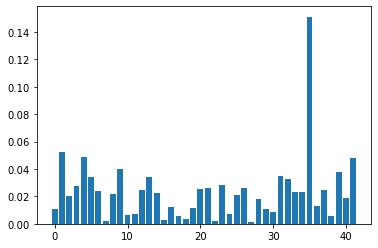

In [120]:
from matplotlib import pyplot
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [121]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       240
           1       0.98      0.92      0.95       240

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480



In [122]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions) 
print(cm)

[[236   4]
 [ 20 220]]


Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

random_classifier = RandomForestClassifier()

parameters = { }

random_grid = GridSearchCV(random_classifier, parameters, cv = 5)
random_grid.fit(X_train, y_train)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

print_results(random_grid)

BEST PARAMS: {}

0.677 (+/-0.221) for {}


In [124]:
joblib.dump(random_grid, './Models/I{}h_F{}h_W{}m_S5m_RF_model.pkl'.format(HoraIni, HoraFin+1,Window))

['./Models/I1h_F2h_W30m_S5m_RF_model.pkl']

In [125]:
y_pred = random_grid.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.21%


In [126]:
from sklearn.metrics import classification_report
predictions = random_grid.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       240
           1       1.00      0.90      0.95       240

    accuracy                           0.95       480
   macro avg       0.96      0.95      0.95       480
weighted avg       0.96      0.95      0.95       480



In [127]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions) 
print(cm)

[[240   0]
 [ 23 217]]


In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


lr = LogisticRegression(max_iter=1000)
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


cv = GridSearchCV(lr, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
print("Logistic Regression")

print_results(cv)
#joblib.dump(cv, '.././Models_Best_Weights/I{}h_F{}h_W{}m_S5m_RF_model.pkl'.format(HoraIni, HoraFin+1,Window))
from sklearn.metrics import classification_report
predictions = cv.predict(X_test)
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions) 
print(cm)
joblib.dump(cv, './Models/I{}h_F{}h_W{}m_S5m_LR_model.pkl'.format(HoraIni, HoraFin+1,Window))

svc = SVC()
parameters = {}


    #'kernel': ['linear', 'rbf'],
    #'C': [0.1, 1, 10]

cv = GridSearchCV(svc, parameters, cv=2)
cv.fit(X_train, y_train.values.ravel())
print("Support Vector Machine")
print_results(cv)
from sklearn.metrics import classification_report
predictions = random_grid.predict(X_test)
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions) 
print(cm)
joblib.dump(cv, './Models/I{}h_F{}h_W{}m_S5m_SVM_model.pkl'.format(HoraIni, HoraFin+1,Window))


Logistic Regression
BEST PARAMS: {'C': 1000}

0.713 (+/-0.165) for {'C': 0.001}
0.73 (+/-0.188) for {'C': 0.01}
0.736 (+/-0.151) for {'C': 0.1}
0.743 (+/-0.13) for {'C': 1}
0.749 (+/-0.124) for {'C': 10}
0.749 (+/-0.126) for {'C': 100}
0.75 (+/-0.126) for {'C': 1000}
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       240
           1       0.99      0.88      0.93       240

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480

[[237   3]
 [ 28 212]]
Support Vector Machine
BEST PARAMS: {}

0.654 (+/-0.128) for {}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       240
           1       1.00      0.90      0.95       240

    accuracy                           0.95       480
   macro avg       0.96      0.95      0.95       480
weighted avg       0.96      0.95      0.95   

['./Models/I1h_F2h_W30m_S5m_SVM_model.pkl']

In [129]:
models = {}
#'SVM', 'MLP',
for mdl in ['SVM','LR','RF','XGB']:
    models[mdl] = joblib.load('./Models/I{}h_F{}h_W{}m_S5m_{}_model.pkl'.format(HoraIni, HoraFin+1,Window,mdl))
    
    
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

    
for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

SVM -- Accuracy: 0.89 / Precision: 0.965 / Recall: 0.808 / Latency: 35.8ms
LR -- Accuracy: 0.935 / Precision: 0.986 / Recall: 0.883 / Latency: 2.0ms
RF -- Accuracy: 0.952 / Precision: 1.0 / Recall: 0.904 / Latency: 27.6ms
XGB -- Accuracy: 0.95 / Precision: 0.982 / Recall: 0.917 / Latency: 12.6ms
